# Notebook for developing diffrax/JAX based reconstruction package for XNH

First, imports:

In [1]:
#SET GPU TO USE:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1,3'

from diffrax import *
import diffrax as dx
from diffrax.functional import *
from diffrax.elements.sources import *
from diffrax import LightField

import jax.numpy as jnp
from jax import random
from jax import grad, jit, vmap
import jax

import optax
import numpy as np
from einops import rearrange

from flax.traverse_util import flatten_dict
from flax.core import unfreeze
import flax.linen as nn

import matplotlib.pyplot as plt

Second, handy functions:

In [2]:
def show_fields(fields, empty_field=None, orientation='landscape'):
    eb = empty_field is not None
    intensity = fields.intensity.squeeze()
    phase = fields.phase.squeeze()

    if orientation.lower() == 'portrait':
        _, axs = plt.subplots(fields.u.shape[0] + eb, 2, figsize=(10, 5*(fields.u.shape[0] + eb)))
        if eb:
            axs[0,0].imshow(empty_field.intensity.squeeze(), cmap='viridis')
            axs[0,1].imshow(empty_field.phase.squeeze(), cmap='hsv')

        if len(axs.shape) == 2:
            for i, ax in enumerate(axs[eb:, :]):
                ax[0].imshow(intensity[i,...], cmap='viridis')
                ax[1].imshow(phase[i,...], cmap='hsv')
            
            axs[0,0].set_title('Intensity')
            axs[0,1].set_title('Phase')

        else:            
            axs[0].imshow(intensity, cmap='viridis')
            axs[1].imshow(phase, cmap='hsv')            
            axs[0].set_title('Intensity')
            axs[1].set_title('Phase')
    else:
        _, axs = plt.subplots(2, fields.u.shape[0] + eb, figsize=(5*(fields.u.shape[0] + eb), 10))
        if eb:
            axs[0,0].imshow(empty_field.intensity.squeeze(), cmap='viridis')
            axs[1,0].imshow(empty_field.phase.squeeze(), cmap='hsv')

        if len(axs.shape) == 2:
            for i, ax in enumerate(axs[:, eb:].T):
                ax[0].imshow(intensity[i,...], cmap='viridis')
                ax[1].imshow(phase[i,...], cmap='hsv')
            
            axs[0,0].set_title('Intensity')
            axs[1,0].set_title('Phase')
        else:            
            axs[0].imshow(intensity, cmap='viridis')
            axs[1].imshow(phase, cmap='hsv')            
            axs[0].set_title('Intensity')
            axs[1].set_title('Phase')

def show_images(images, empty_image=None, orientation='landscape'):
    eb = empty_image is not None
    intensity = images.squeeze()

    if orientation.lower() == 'portrait':
        _, axs = plt.subplots(intensity.shape[0] + eb, 1, figsize=(5, 5*(intensity.shape[0] + eb)))
    else:
        _, axs = plt.subplots(1, intensity.shape[0] + eb, figsize=(5*(intensity.shape[0] + eb), 5))

    if eb:
        axs[0].imshow(empty_image.squeeze(), cmap='viridis')
    for i, ax in enumerate(axs[eb:]):
        ax.imshow(intensity[i,...], cmap='viridis')
    axs[0].set_title('Intensity')

def show_params(params):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    plt.subplot(141, title='Delta:')
    plt.imshow(params['delta_param'].squeeze())
    plt.colorbar()

    plt.subplot(142, title='Beta:')
    plt.imshow(params['beta_param'].squeeze())
    plt.colorbar()

    if 'input_field_param' in params:
        plt.subplot(143, title='Input Intensity:')
        plt.imshow(params['input_field_param'].intensity.squeeze(), cmap='viridis')
        plt.colorbar()

        plt.subplot(144, title='Input Phase:')
        plt.imshow(params['input_field_param'].phase.squeeze(), cmap='hsv')
        plt.colorbar()

# def propagate(field, dz, n, D): # here dz is distance to propogate wave
#     Nf = jnp.max((D / 2) ** 2 / (field.wavelengths * dz))
#     M = field.u.shape[1]
#     # assert M > (4 * Nf)
#     Q = M / (4 * Nf)
#     N = int(jnp.ceil((Q * M) / 2) * 2)
#     N_pad = max(0, int(N - M))
#     print(N_pad)
#     # TODO: update to new method
#     return prop_fcn(field, z=dz, n=n, N_pad=N_pad)

Now, let's define some aspects of our system (based on CBxs_lobV_top_30nm at ESRF beamline i16a):

In [3]:
mul_factor = 1000 # 1e6 # conversion factor

lambda_ =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
lambda_ratios = 1.0 # ratio of wavelengths
du_eff = 0.03 # effective pixel size of sample on detector (microns)
du = 3e-6 * mul_factor # (microns) documented pixelsize_detector in ESRF script
z_total = 1.208 * mul_factor # distance from focus point to detector (microns)
zs_f2s = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * mul_factor # distances source to sample (microns) 
dz = 1. # depth of slice in microns
zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
n = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF
D = 30e-3 # aperture width in microns (corresponding to *smallest beam width at focal point post Kirkpatrick-Baez mirrors)

# And pick a propagation calculation method (transfer, transform, or exact)
# prop_fcn = exact_propagate
prop_fcn = transform_propagate


Then get and display Siemens star test object (then make it into a phase object) and use it as ground truth (gt):

N_pad = 1024
Delta range = [0.0, 0.3149999976158142]
Beta range = [0.0, 0.0044999998062849045]


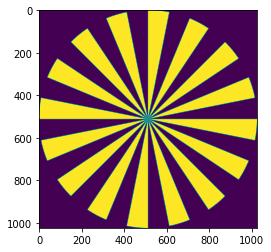

In [4]:
data = plt.imread('./Siemens_star.svg.png')
# data = repeat(jnp.abs(jnp.mean(data, axis=-1)), 'h w -> b h w 1', b = zs_f2s.size) 
data = jnp.expand_dims(jnp.expand_dims(jnp.abs(jnp.mean(data, axis=-1)), 0), -1) # 'h w -> b h w 1'
n_pixels = data.shape[1]
# D = n_pixels * du#_eff # effective aperture width in microns
Nf = jnp.max((D / 2) ** 2 / (lambda_ * z_total)) # Fresnel number
# Q = n_pixels / (4 * Nf)
# N = int(jnp.ceil((Q * n_pixels) / 2) * 2)
# N_pad = max(0, int(N - n_pixels))
N_pad = int(jnp.ceil((n_pixels - (4 * Nf)) / 2) * 2)
assert (N_pad + n_pixels) > (4 * Nf)

print(f'N_pad = {N_pad}')
plt.imshow(data[0,...,0].squeeze())

# delta and beta should be 4d Tensors
delta = data * 1.2600 # phase change corresponding to osmium
beta = data * (1 - 0.98200) # 1 minus the extinction coefficient
print(f'Delta range = [{delta.min()}, {delta.max()}]')
print(f'Beta range = [{beta.min()}, {beta.max()}]')

Now let's make the lightfields hitting the sample and display their intensity and phase:

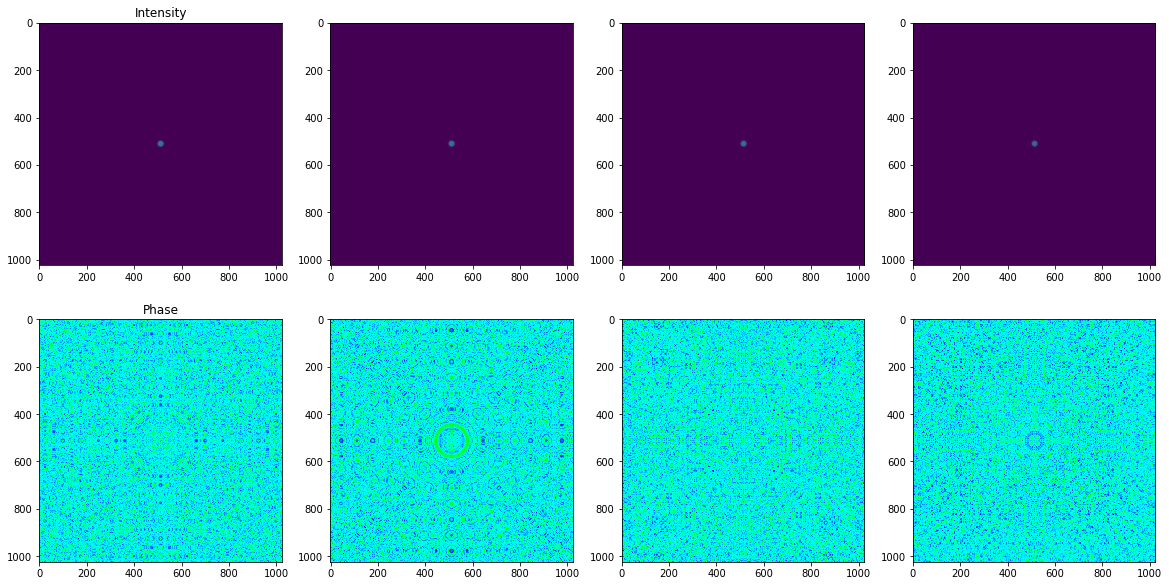

In [5]:
# src_field = create_field(square_aperture(N_pad), (n_pixels, n_pixels), D / n_pixels, lambda_, lambda_ratios)
# in_fields = create_field(pointsource(zs_f2s, D, n), (n_pixels, n_pixels), du_eff, lambda_, lambda_ratios)
# in_fields = create_field(pointsource(zs_f2s, D, n), (n_pixels, n_pixels), D / n_pixels, lambda_, lambda_ratios)
src_field = create_field(pointsource(dz, D, n), (n_pixels, n_pixels), D / n_pixels, lambda_, lambda_ratios)
in_fields = prop_fcn(field=src_field, z=zs_f2s.reshape((len(zs_f2s),1,1,1)), n=n, N_pad=N_pad)
show_fields(in_fields)

Now let's make some projections:

In [6]:
def phasechange(field: LightField, delta: jnp.ndarray, beta: jnp.ndarray, dz: float) -> LightField:
    k = 2 * jnp.pi / field.wavelengths
    u = field.u * jnp.exp(-1j * k * dz * (delta - 1j * beta))
    return field.replace(u=u)

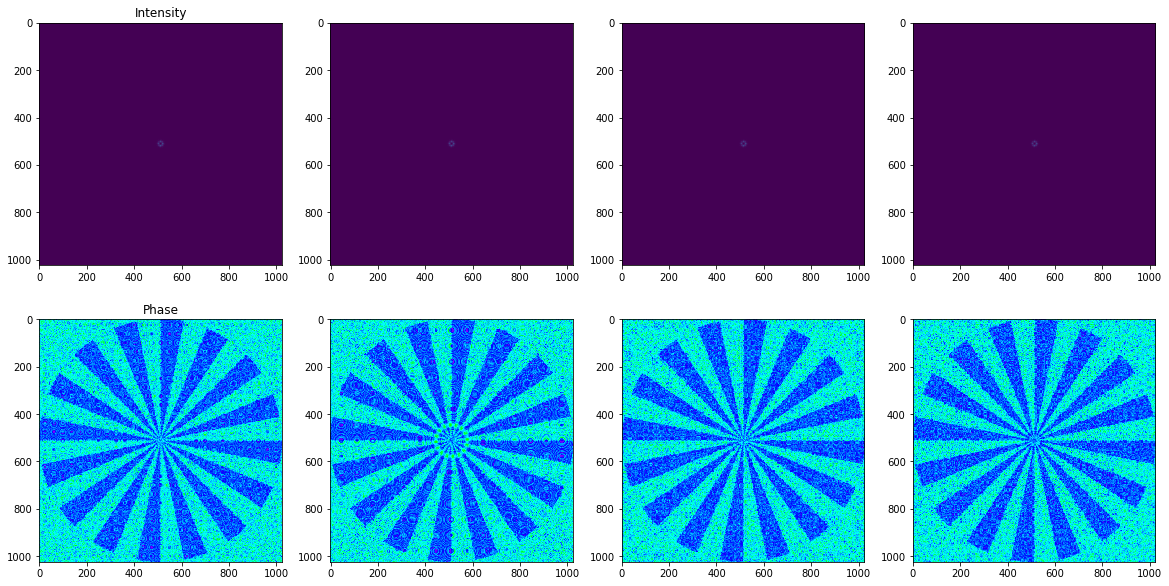

In [7]:
out_fields = phasechange(in_fields, delta, beta, dz=dz)
show_fields(out_fields)

Let's add free space propagation after the sample:

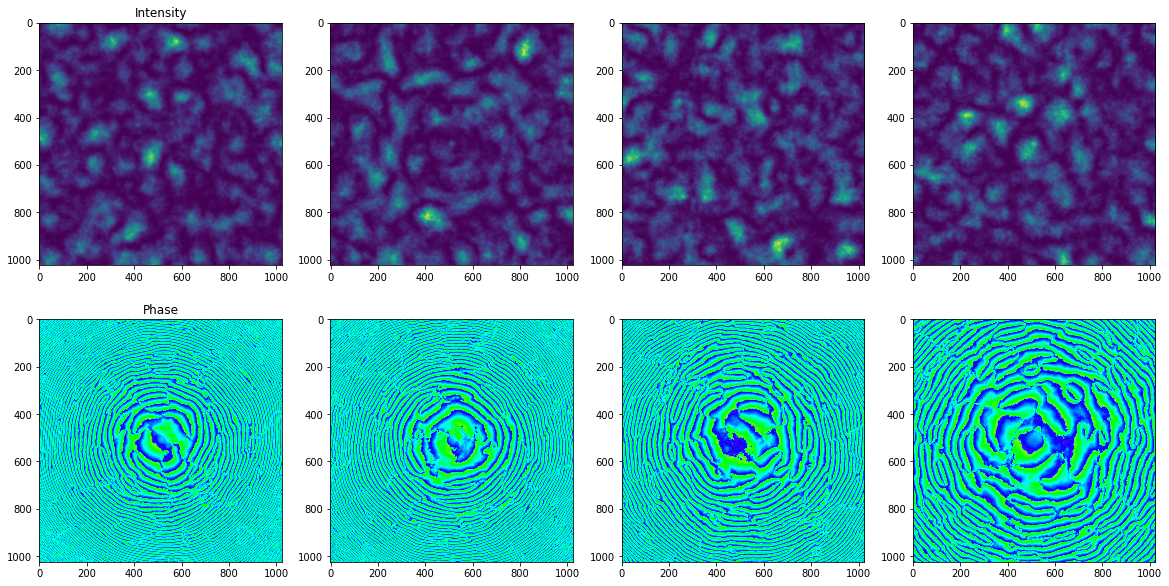

In [8]:
sensor_fields = prop_fcn(field=out_fields, z=zs_s2d.reshape((len(zs_s2d),1,1,1)), n=n, N_pad=N_pad)
show_fields(sensor_fields)

Finally, let's collect everything as ground truths for different projection distances and the empty beam image:

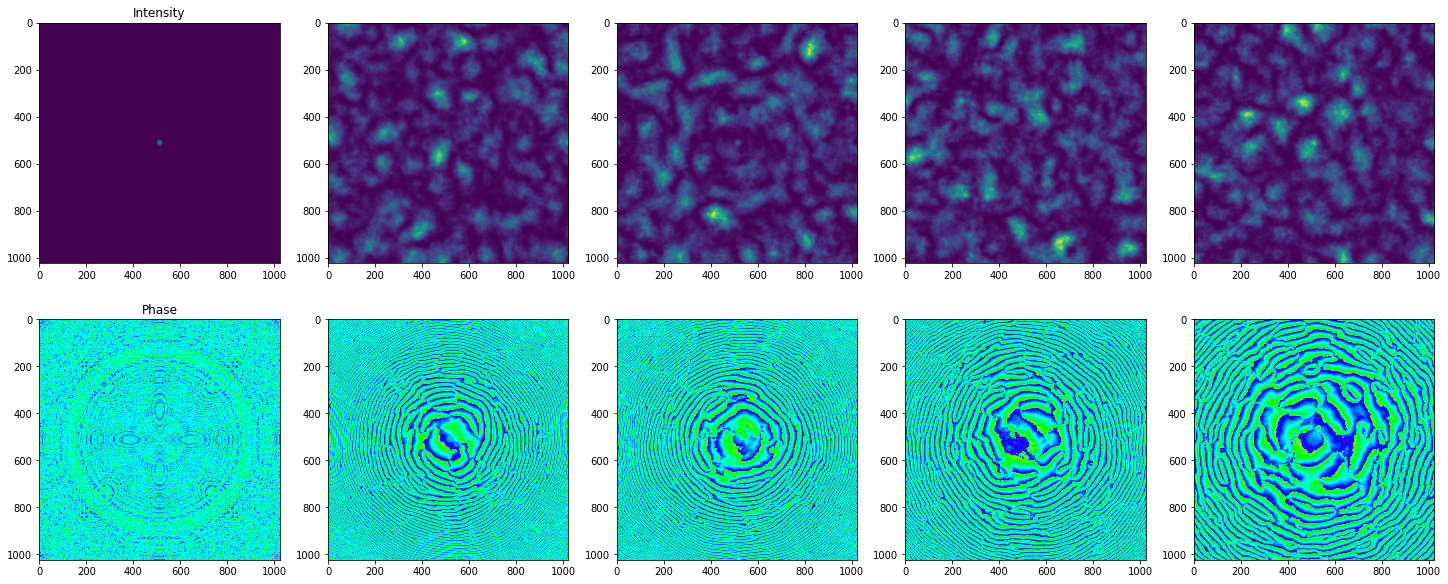

In [9]:
gt_sample_images = sensor_fields.intensity # these would be the sensor readings for each distance
gt_empty_beam = prop_fcn(field=src_field, z=z_total, n=n, N_pad=N_pad)
gt_empty_beam_image = gt_empty_beam.intensity
gt_params = {'delta_param': delta, 'beta_param': beta, 'input_field_param': src_field}

show_fields(sensor_fields, gt_empty_beam)

### Now let's see if we can reconstruct the sample from the sensor images

First, let's make some necessary variables, including making objects for parts of our imaging system.
Let's first remember the elements of our system, using the thin slice approximation for modeling the sample volume:
1) ```input_field```: Coherent monochromatic X-ray beam of wavelength ```lambda_``` and refractive index ```n``` in the system, focused by Kirkpatrick-Baez mirrors distances ```[zs_f2s]``` from the sample, and distance ```z_total``` from the detector/sensor.
2) ```phase_object```: The sample volume to estimate, modeled as a thin phase object with ```delta``` refractive index and ```beta``` extinction coefficient, ```[zs_f2s]``` from the beam focal point, and ```[zs_s2d]``` from the detector, with depth ```dz```.
3) ```propagation```: Propgation of the beam exiting the ```phase_object``` some ```[zs_s2d]``` distances to the detector/sensor, which should have some shot noise/manufacturing defects that produces the final images. TODO: Add noise OR **make sensor object incorporating noise/response model**

In [26]:
class MultiDistance(nn.Module):    
    # du_eff: float = 0.03 # effective pixel size of detector (microns)
    # du: float = 3e-6 # (microns) documented pixelsize_detector in ESRF script
    z_total: float = 1.208 * 1000 # distance from focus point to detector (microns)
    zs_f2s: jnp.array = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
    dz: float = 1. # depth of slice in microns
    # zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
    lambda_: jnp.array =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
    lambda_ratios: jnp.array = 1.0 # ratio of wavelengths
    n: float = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF
    field_shape: int = 1024 #TODO: Determine if there should also be n_pixels
    D: float = 30e-3 # aperture width in microns (corresponding to *smallest beam width at focal point post Kirkpatrick-Baez mirrors)
    
    @property
    def max_Npad(self):
        Nf = np.max((self.D / 2) ** 2 / (self.lambda_ * self.z_total)) # Fresnel number
        # N = np.ceil(1 / (8 * Nf)) * 2
        # N_pad = int(np.clip(N - self.field_shape, 0, None))
        return int(np.clip(np.ceil((self.field_shape - (4 * Nf)) / 2) * 2, 0, None))
    
    @classmethod
    def phasechange(self, delta, beta, field: LightField) -> LightField:
        k = 2 * jnp.pi / field.wavelengths
        u = field.u * jnp.exp(-1j * k * self.dz * (delta - 1j * beta))
        return field.replace(u=u)

    def setup(self):        
        self.input_field = create_field(pointsource(self.dz, self.D, self.n), (self.field_shape, self.field_shape), self.D / self.field_shape, self.lambda_, self.lambda_ratios)

        # self.input_field = self.param('input_field_param', 
        #     lambda key, dz, shape, D, n, lambda_, lambda_ratios: create_field(pointsource(dz, D, n), (shape, shape), D / shape, lambda_, lambda_ratios), 
        #     self.dz, self.field_shape, self.D, self.n, self.lambda_, self.lambda_ratios)

        data = plt.imread('./Siemens_star.svg.png')
        data = jnp.expand_dims(jnp.expand_dims(jnp.abs(jnp.mean(data, axis=-1)), 0), -1) # 'h w -> b h w 1'
        delta = data * 1.26
        beta = data * (1 - 0.982) + 0.01

        self.delta = self.param('delta_param', 
            lambda key, delta: delta, 
            # lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            # lambda key, shape: random.uniform(key, (1, shape, shape, 1)),
            # self.field_shape)
            delta)

        self.beta = self.param('beta_param', 
            lambda key, beta: beta, 
            # lambda key, shape: jnp.zeros((1, shape, shape, 1)), 
            # lambda key, shape: random.uniform(key, (1, shape, shape, 1), maxval=0.1),
            # self.field_shape)        
            beta)

        self.z1s = jnp.array(self.zs_f2s).reshape((len(self.zs_f2s),1,1,1))
        # self.z1s = self.param('z1s_param', 
        #     lambda key, zs: jnp.array(zs).reshape((len(zs),1,1,1)), # make properly dimensioned array (b x 1 x 1 x 1)
        #     self.zs_f2s)
    
    def __call__(self) -> LightField:
        empty_beam_field = prop_fcn(field = self.input_field, z = self.z_total, n = self.n, N_pad = self.max_Npad) # 1 x h x w x 1
        sample_fields = prop_fcn(field = self.input_field, z = self.z1s, n = self.n, N_pad = self.max_Npad) 
        sample_fields = self.phasechange(self.delta, self.beta, sample_fields)
        sample_fields = prop_fcn(field = sample_fields, z = self.z_total - self.z1s - self.dz, n = self.n, N_pad = self.max_Npad)
        
        return empty_beam_field, sample_fields

Instantiate system and extract states vs. parameters. (Parameters are differentiable/trainable, states are not). Here we see the trainable parameters for the phase object: ```delta```, ```beta```, ```z1s``` (distance from beam focus to sample) and ```input_field```:

In [27]:
multi = MultiDistance()
key = random.PRNGKey(13)
variables = multi.init(key)
state, params = variables.pop('params') # Split state and params to optimize for
del variables # Delete variables to avoid wasting resources

flatten_dict(unfreeze(params)).keys()

dict_keys([('beta_param',), ('delta_param',)])

Okay. Let's take a look at our naive outputs before training:

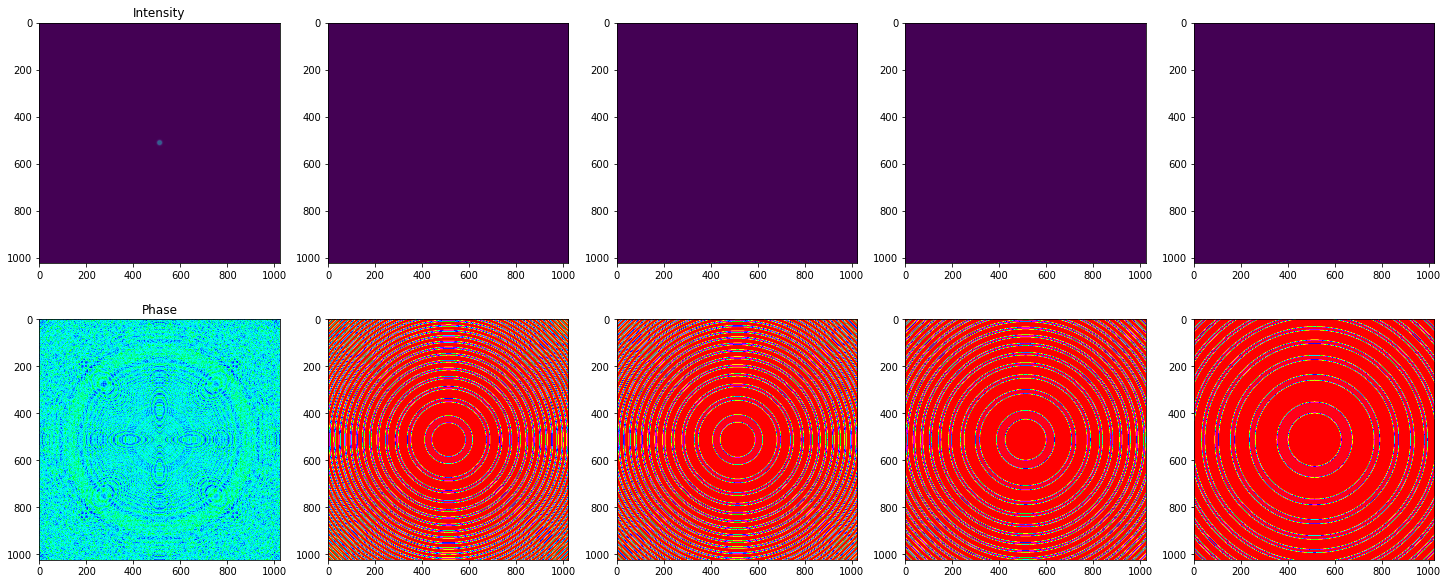

In [28]:
empty, fields = multi.apply({'params': params})
show_fields(fields, empty)

Well, that's not right. So let's define loss and step functions to train with:

In [29]:
def loss(params, gt_empty: jnp.array, gt_sample: jnp.array):
    sim_empty, sim_sample = multi.apply({'params': params})
    # L2 Loss
    # loss_empty = jnp.nanmean((gt_empty - sim_empty.intensity)**2)
    loss_sample = jnp.nanmean((gt_sample - sim_sample.intensity)**2) * sim_sample.shape[0] # give sample measurements equal weight 
    # # L1 Loss
    # loss_empty = jnp.nanmean(abs(gt_empty - sim_empty.intensity))
    # loss_sample = jnp.nanmean(abs(gt_sample - sim_sample.intensity)) * sim_sample.shape[0] # give sample measurements equal weight to empty beam
    # loss_empty = optax.huber_loss(sim_empty.intensity, gt_empty).mean()
    # loss_sample = optax.huber_loss(sim_sample.intensity, gt_sample).mean() * sim_sample.shape[0] # give sample measurements equal weight to empty beam
    # return (loss_empty + loss_sample) / (sim_sample.shape[0] + 1) # normalize loss so it doesn't depend on the number of sample images
    return loss_sample / sim_sample.shape[0] # normalize loss so it doesn't depend on the number of sample images
    
def get_step_fn(loss_fn, optimizer):
    """Returns update function function."""

    def step(params, opt_state, *args):
        loss, grads = jax.value_and_grad(loss_fn)(params, *args)

        # Applying updates
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss, grads

    return jit(step)

And now see where we stand before any training:

In [30]:
naive_grads = grad(loss)(params, gt_empty_beam_image, gt_sample_images)
naive_loss = loss(params, gt_empty_beam_image, gt_sample_images)

Loss: 0.0001772408577380702
Gradients - Delta: 0.0, Beta: 0.0


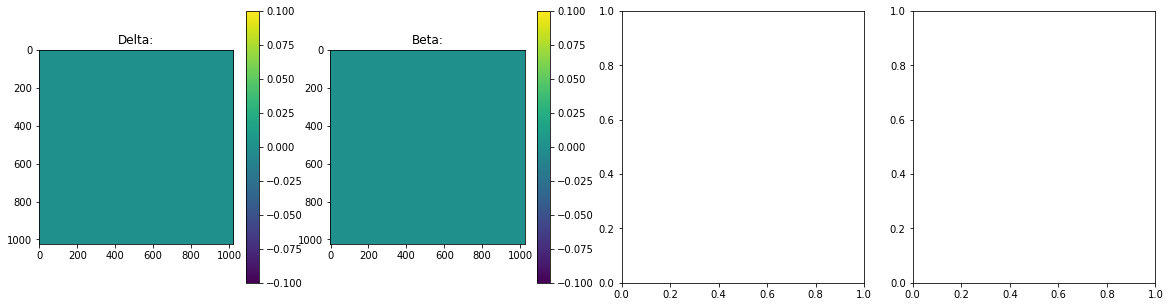

In [35]:
print(f'Loss: {naive_loss}')
print(f"Gradients - Delta: {naive_grads['delta_param'].max()}, Beta: {naive_grads['beta_param'].max()}")
show_params(naive_grads)

Now let's give training a shot, using an Adam ~~AdaBelief~~ optimizer:

In [33]:
# step_sizes = {'beta_param': 0.01, 'delta_param': 0.01, 'input_field_param': 0.01, 'z1s_param': 1e-9}
init_lr = 1e-8
num_epochs = 10

import time

# grad_fcn = jit(grad(loss))

# initialize optimizer
optimizer = optax.adam(init_lr)
# optimizer = optax.adabelief(init_lr)
opt_state = optimizer.init(params)
step = get_step_fn(loss, optimizer)

for epoch in range(num_epochs):
  start_time = time.time()
  params, opt_state, loss_, grads = step(params, opt_state, gt_empty_beam_image, gt_sample_images)
  # grads = grad_fcn(params, gt_empty_beam_image, gt_sample_images)
  # # grads = grad(loss)(params, gt_empty_beam_image, gt_sample_images)
  # updates, opt_state = optimizer.update(grads, opt_state)
  # params = optax.apply_updates(params, updates)
  epoch_time = time.time() - start_time
  
  # print("Epoch {} in {:0.2f} sec, loss = {:0.3f}".format(epoch, epoch_time, loss(params, gt_empty_beam_image, gt_sample_images)))
  print("Epoch {} in {:0.2f} sec, loss = {:0.3f}".format(epoch, epoch_time, loss_))

Epoch 0 in 8.22 sec, loss = 0.000
Epoch 1 in 0.00 sec, loss = 0.000
Epoch 2 in 0.00 sec, loss = 0.000
Epoch 3 in 0.00 sec, loss = 0.000
Epoch 4 in 0.00 sec, loss = 0.000
Epoch 5 in 0.00 sec, loss = 0.000
Epoch 6 in 0.00 sec, loss = 0.000
Epoch 7 in 0.00 sec, loss = 0.000
Epoch 8 in 0.00 sec, loss = 0.000
Epoch 9 in 0.00 sec, loss = 0.000


What do the gradients look like?

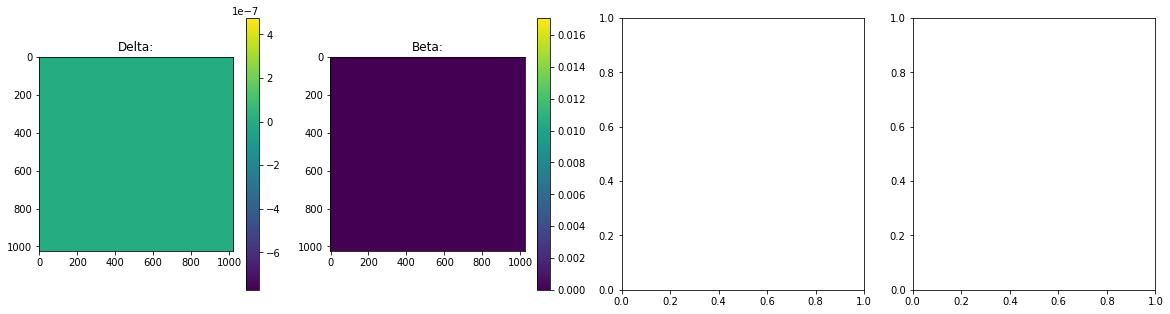

In [ ]:
show_params(grads)

Any improvement?

Starting Loss: 0.007165461778640747 ---10 epochs training---> Current Loss: 0.0071654594503343105
GT parameters (top) vs. current trained parameters (bottom)


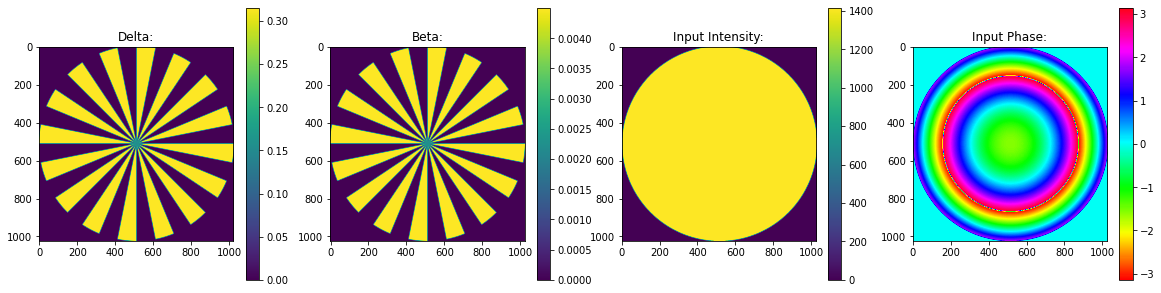

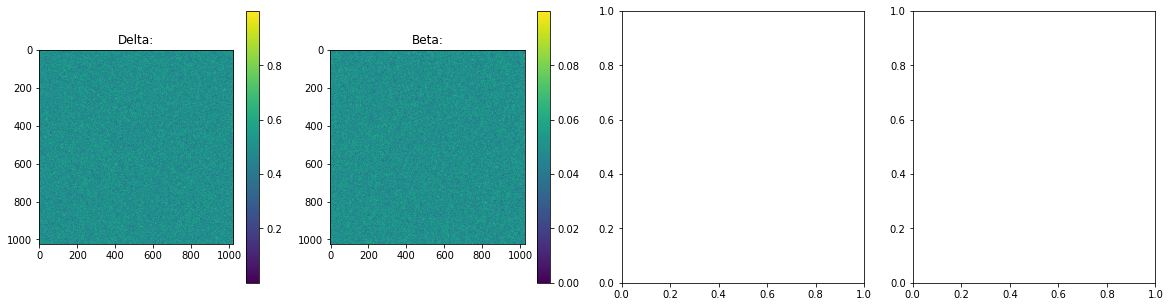

In [ ]:
print(f'Starting Loss: {naive_loss} ---{num_epochs} epochs training---> Current Loss: {loss(params, gt_empty_beam_image, gt_sample_images)}')

print('GT parameters (top) vs. current trained parameters (bottom)')
show_params(gt_params)
show_params(params)

GT Images (top) vs. Simulated Images (bottom)


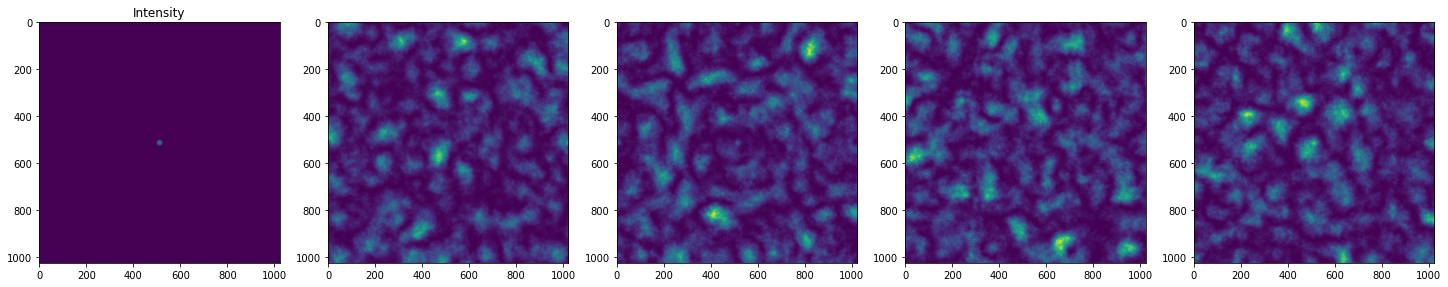

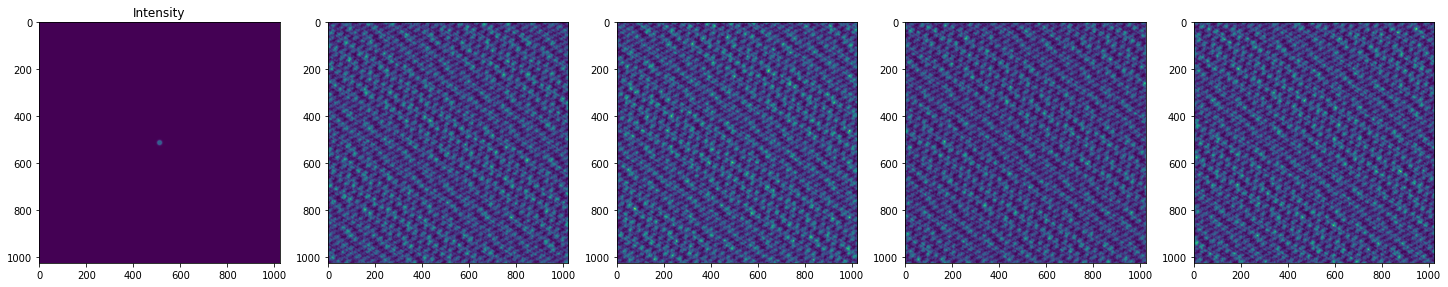

In [ ]:
print('GT Images (top) vs. Simulated Images (bottom)')
show_images(gt_sample_images, gt_empty_beam_image)

empty, fields = multi.apply({'params': params})
show_images(fields.intensity, empty.intensity)

Now if we run it for a while:

In [20]:
init_lr = 1e-8

# initialize optimizer
optimizer = optax.adam(init_lr)
# optimizer = optax.adabelief(init_lr)
opt_state = optimizer.init(params)
step = get_step_fn(loss, optimizer)

In [21]:
from tqdm import trange
num_epoch = 50000
num_stop = 1000 # how many iterations with delta_loss == 0 to have before quitting

old_loss = naive_loss
no_loss_cnt = 0
progress = trange(num_epoch)
for epoch in progress:
  params, opt_state, current_loss, grads = step(params, opt_state, gt_empty_beam_image, gt_sample_images)  
  delta_loss = old_loss - current_loss
  no_loss_cnt += (delta_loss == 0.)
  no_loss_cnt *= (delta_loss == 0.)
  if no_loss_cnt >= num_stop: break
  progress.set_postfix({'delta_loss': delta_loss, 'current_loss': current_loss, 'no_loss_cnt': no_loss_cnt})
  old_loss = current_loss

100%|██████████| 5000/5000 [01:37<00:00, 51.51it/s, delta_loss=9.313226e-09, current_loss=0.0048861755, no_loss_cnt=0]  


Let's see how we did:

GT Images (top) vs. Simulated Images (bottom)


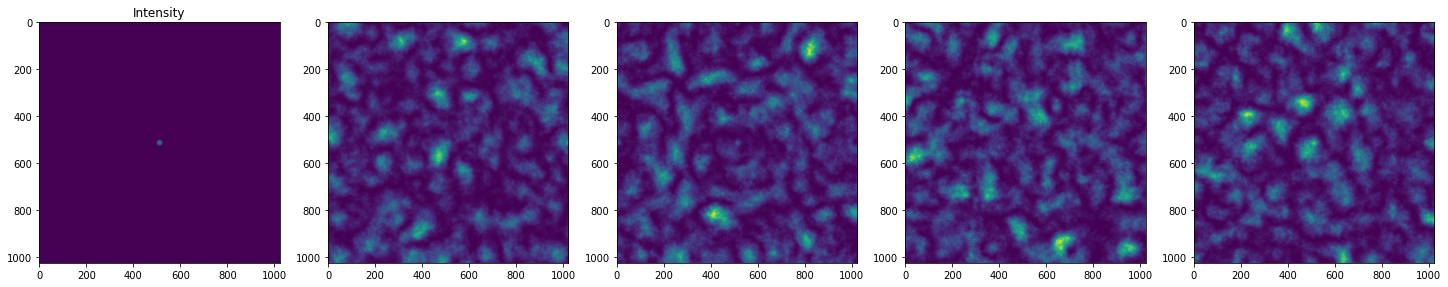

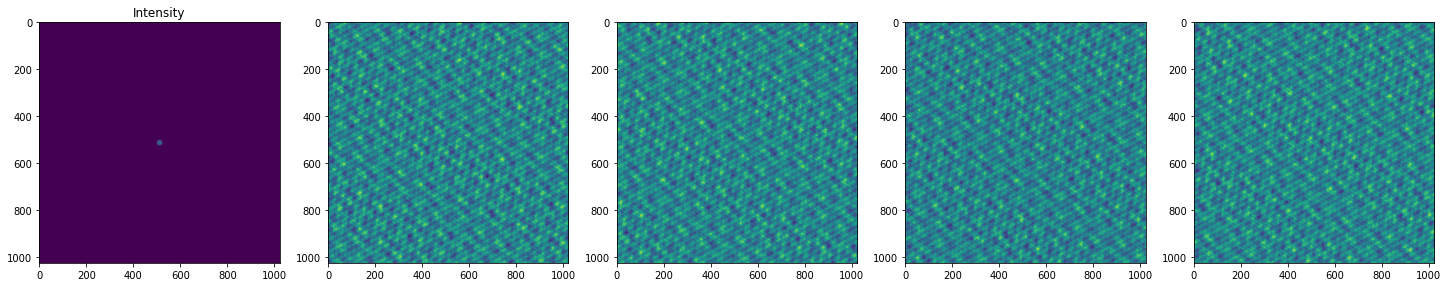

In [22]:
print('GT Images (top) vs. Simulated Images (bottom)')
show_images(gt_sample_images, gt_empty_beam_image)

empty, fields = multi.apply({'params': params})
show_images(fields.intensity, empty.intensity)

GT parameters (top) vs. current trained parameters (bottom)


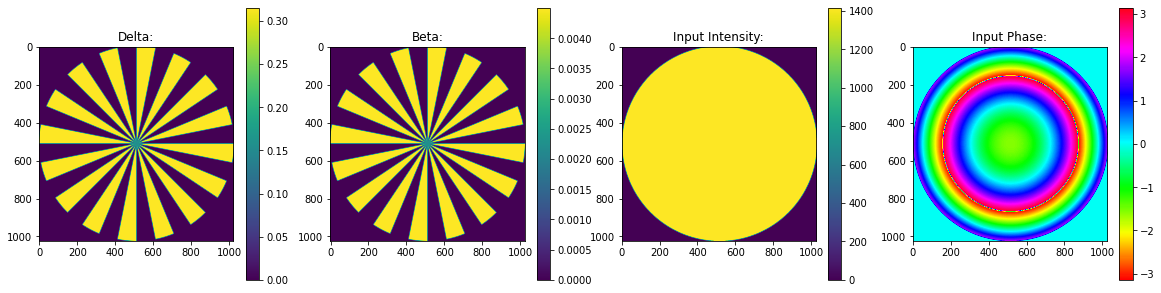

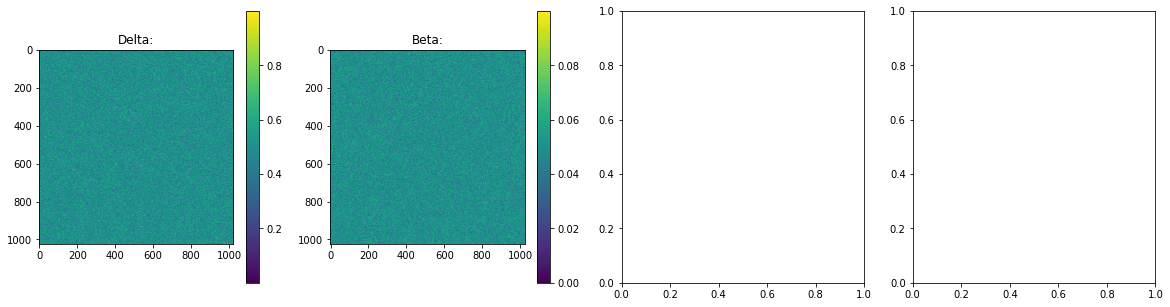

In [23]:
print('GT parameters (top) vs. current trained parameters (bottom)')
show_params(gt_params)
show_params(params)

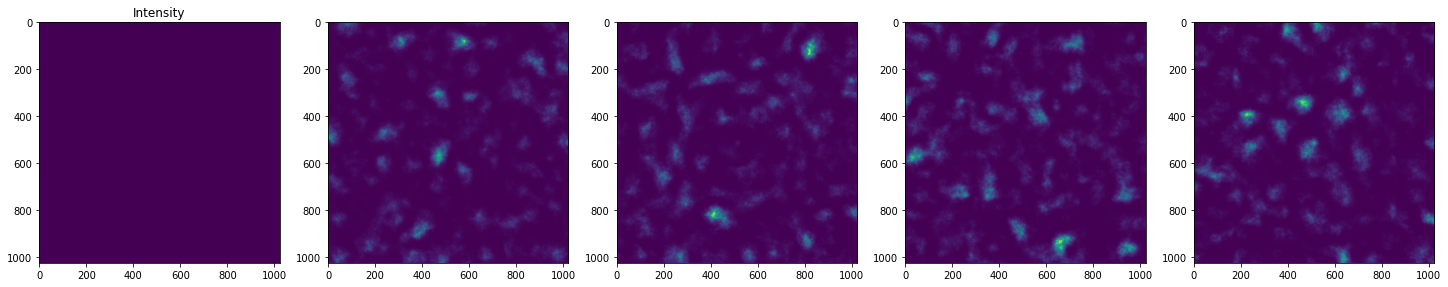

In [36]:
def show_loss(params, gt_empty: jnp.array, gt_sample: jnp.array):
    sim_empty, sim_sample = multi.apply({'params': params})    
    loss_empty = optax.huber_loss(sim_empty.intensity, gt_empty)
    loss_sample = optax.huber_loss(sim_sample.intensity, gt_sample)
    show_images(loss_sample, loss_empty)

show_loss(params, gt_empty_beam_image, gt_sample_images)

### Deprecated Dev Section:

In [ ]:
old_loss = naive_loss
no_loss_cnt = 0    
grad_fcn = jit(grad(loss))
progress = trange(num_epoch)
for epoch in progress:
  grads = grad_fcn(params, gt_empty_beam_image, gt_sample_images)
  # grads = grad(loss)(params, gt_empty_beam_image, gt_sample_images)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  current_loss = loss(params, gt_empty_beam_image, gt_sample_images)
  delta_loss = old_loss - current_loss
  if delta_loss == 0.:
    no_loss_cnt += 1
  else:
    no_loss_cnt = 0    
  if no_loss_cnt >= num_stop: break
  progress.set_postfix({'delta_loss': delta_loss, 'no_loss_cnt': no_loss_cnt})
  old_loss = current_loss

In [ ]:
class SingleProjection(nn.Module):    
    du: float = 0.03 # effective pixel size of detector (microns) (note: documented as pixelsize_detector = 3e-6 in ESRF script?)
    z_total: float = 1.208 * 1000 # distance from focus point to detector (microns)
    zs_f2s: jnp.array = jnp.array([0.012080, 0.012598, 0.014671, 0.018975]) * 1000 # distances source to sample (microns) 
    dz: float = 1. # depth of slice in microns
    # zs_s2d = z_total - zs_f2s - dz # distances sample to detector (microns) 
    lambda_: jnp.array =  7.25146e-5 # wavelength in microns for 17kEV (~3.62573e-05 um for 33kEV)
    lambda_ratios: jnp.array = 1.0 # ratio of wavelengths
    n: float = 0.999999999 # refractive index of x-rays is slightly below unity according to ESRF
    field_shape: int = 1024 #TODO: Determine if there should also be n_pixels

    @property
    def max_Npad(self):
        Nf = jnp.max((self.du / 2) ** 2 / (self.lambda_ * self.z_total))
        N = jnp.ceil(1 / (8 * Nf)) * 2
        return jnp.clip(N - self.field_shape, 0).astype(int)    
    
    @classmethod
    def phasechange(self, field: LightField) -> LightField:
        k = 2 * jnp.pi / field.wavelengths
        u = field.u * jnp.exp(-1j * k * self.dz * (self.delta - 1j * self.beta))
        return field.replace(u=u)

    @classmethod
    def project(self, z1):
        sample_field = transfer_propagate(field = self.input_field, z = z1, n = self.n, N_pad = self.max_Npad)
        sample_field = self.phasechange(sample_field)
        return prop_fcn(field = sample_field, z = self.z_total - z1 - self.dz, n = self.n, N_pad = self.max_Npad)

    def setup(self):        
        self.input_field = self.param('input_field_param', 
            lambda key, shape, du, n, lambda_, lambda_ratios: create_field(pointsource(1e-9, shape*du, n), (shape, shape), du, lambda_, lambda_ratios), 
            self.field_shape, self.du, self.n, self.lambda_, self.lambda_ratios)

        self.delta = self.param('delta_param', 
            lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            self.field_shape)

        self.beta = self.param('beta_param', 
            lambda key, shape: jnp.ones((1, shape, shape, 1)), 
            self.field_shape)        

        self.z1s = self.param('z1s_param', 
            lambda key, zs: zs, 
            self.zs_f2s)
    
    def __call__(self, z1) -> LightField:
        if z1 is None:
            field = prop_fcn(field = self.input_field, z = self.z_total, n = self.n, N_pad = self.max_Npad) # 1 x h x w x 1
        else:
            field = self.project(z1)
                
        return field

projector = SingleProjection()
key = random.PRNGKey(42)

variables = projector.init(key, None)
state, params = variables.pop('params') # Split state and params to optimize for
# del variables # Delete variables to avoid wasting resources

flatten_dict(unfreeze(params)).keys()

field = projector.apply(variables, None)
